# 1. Call center data modeling

Complete the call center data modeling assignment we start in the Pre-class work and Activity 2
breakouts of Session 2.2. You may re-use and build on all code or any other work from the class
session. In class, we completed the Bayesian data modeling problem for 1 hour of the day. In this
assignment, you need to do the same analysis for all 24 hours of the day

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call_center.csv')

In [2]:
# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

In [49]:
'''
Instead of using the functions from the 2.2 Breakout Session,
I used a conjugate prior approach, taking advantage of the fact
that a exponential likelihood function and a gamma conjugate prior 
gives a gamma posterior distribtuion with hyper parameters:
    - posterior alpha = prior alpha + N
    - posterior beta = posterior beta + Summation of likelihoods
This is an efficient way to calculate the posterior distribution.
'''

#establish lambda values of calls per minute
# for the prior distribution
lambdas = np.linspace(0, 10, 501)[1:]

#using same prior gamma parameters
a_prior = 1
b_prior = 0.25

#empty list for posterior distribution for each hour, each hour's
#distribution mean and 98% percentile bounds.
posterior24 = []
mean24 = []
percentile24 = []

for i in range(24):
   
        #new hyperparatmers
        a_posterior = a_prior + len(waiting_times_per_hour[i])
        b_posterior = b_prior + sum(waiting_times_per_hour[i])
    
        #new posterior distributions
        post = sts.gamma(a_posterior, scale= 1/b_posterior).pdf(lambdas)
        posterior24.append(post)
        
        #expected value by hyperparameter
        m = (a_posterior/b_posterior)
        mean24.append(m)
        
        #percentile bounds using ppf method
        lower = sts.gamma(a_posterior, scale= 1/b_posterior).ppf(0.02)
        upper = sts.gamma(a_posterior, scale= 1/b_posterior).ppf(0.98)
        percentile24.append([lower,upper])
       
#positive & negative error bars
pos_yerr = []
neg_yerr = []

for l in range(24):
        p = percentile24[l][1] - mean24[l]
        pos_yerr.append(p)
        n = mean24[l] - percentile24[l][0]
        neg_yerr.append(n)

#for plotting error bars
yerr = (pos_yerr, neg_yerr)        


## 1. Compute a 98% posterior confidence interval over the number of calls per minute (the call rate λ ) for each hour of the day — so you will have 24 confidence intervals. Also, compute the posterior mean of λ for each hour of the day.


In [66]:
for i in range(24):
    print("The 98% posterior confidence interval in hour", i, "is", percentile24[i])
    
print("____________________________________________________________________________________")

for i in range(24):
    print("The posterior call rate in hour", i, "is", mean24[i])

The 98% posterior confidence interval in hour 0 is [0.034164244371206805, 0.19667994023038424]
The 98% posterior confidence interval in hour 1 is [0.022811718201854719, 0.15779841566968447]
The 98% posterior confidence interval in hour 2 is [0.034926463369483879, 0.17483906728896756]
The 98% posterior confidence interval in hour 3 is [0.10658157652815042, 0.43604962160068533]
The 98% posterior confidence interval in hour 4 is [0.28552055071120547, 0.634188818934312]
The 98% posterior confidence interval in hour 5 is [0.66913129116414827, 1.1733273552667638]
The 98% posterior confidence interval in hour 6 is [1.2725477661840952, 1.9461113776313612]
The 98% posterior confidence interval in hour 7 is [2.4504016845400458, 3.3471165962673139]
The 98% posterior confidence interval in hour 8 is [3.727504948752101, 4.8221459459801137]
The 98% posterior confidence interval in hour 9 is [5.1140859399775147, 6.3788168270362053]
The 98% posterior confidence interval in hour 10 is [7.53472894947617

## 2. Present your results graphically using Matplotlib. Make a plot that looks like the one below. Each dot is at the posterior mean and each line shows a 98% confidence interval for a λ. You can use the errorbar() function in the plotting library to do this.

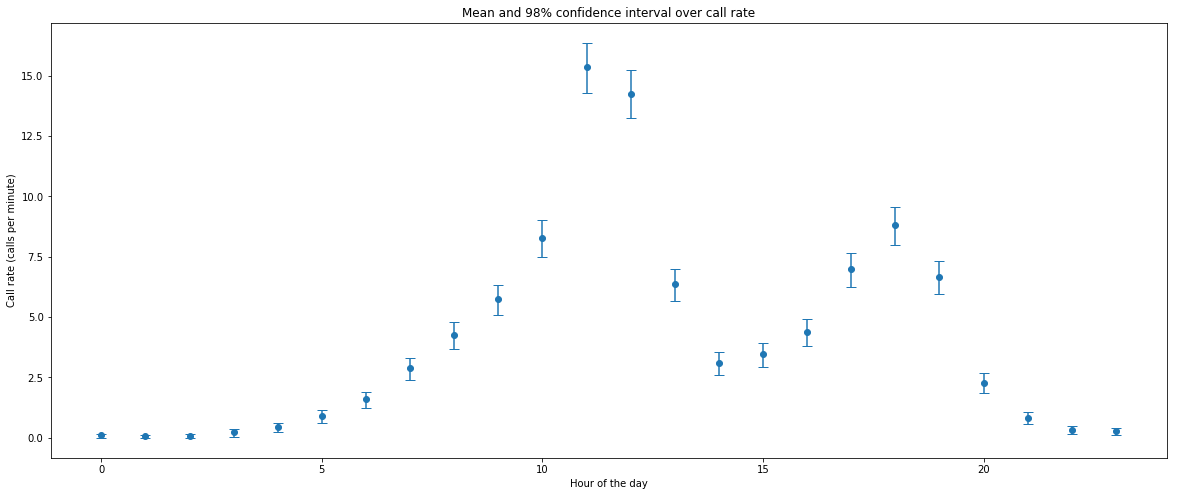

In [50]:
#plotting graph
plt.figure(figsize=(20, 8))
plt.errorbar(range(24), mean24, yerr = yerr,fmt='o', capsize=5)
plt.title('Mean and 98% confidence interval over call rate')
plt.xlabel('Hour of the day')
plt.ylabel('Call rate (calls per minute)')
plt.show()

## 3. Write a paragraph (100–200 words) to accompany your plot and present your findings to the client. Carefully summarize how many calls you expect during different parts of the day, and how much uncertainty there is in your estimates. Remember that the client is not an expert in statistics, so make it easy for them to understand. You may also make additional plots to help communicate your results.

Summarising the data briefly, we can see that in general, the number of phone calls is low during the night and high during the day time, and the variation in call rates are higher when there are the call rate is higher. The model matches intuition, since expect people to call during the day and not at night, and there is a higher chance for the call rate to fluctuate if there are more calls than compared to when there are few calls.

From midnight 12am to 10am in the morning, the number of phone calls steadily increases from close to 0 to around 8 calls a minute at 10am, with uncertainty in our estimates growing by the hour. This uncertainty can be explained by how we are less certain about our estimates when there are more calls per minute, since there could be minutes with many calls and few calls, and in peak periods, this would mean we are less certain about how many calls there would be. 

There's a high peak period at midday hours of 11am and 12pm at approximately 14 calls a minute give or take 2 calls a minute, and a smaller peak period in the late afternoon of 5pm to 7pm. The call rate subsequently trails off following 7pm into midnight and the next morning. Similarly, we can observe how the variation in calls per minute is high, almost 1 or 2 calls a minute in peak periods, to maybe 1 call every 30 seconds in less busy periods. 

This model is intuitive, as we can expect people to call during lunch hour and after work hours, which mostly correspond to the peak periods in our model, and not to call during the middle of the night, which also corresponds to the less busy periods in the model.

# 2. Stretch goal (optional)

Explain how the compute_posterior function (reproduced below) from Lesson 2.2 works. We
discussed the function briefly in class. For a complete answer you need to address all the points
below. You can also add any other information you think is relevant to the techniques used in the
function.

In [296]:
def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

The purpose of the function is to multiply the prior and likelihood passed as input arguments
and to return the posterior as output. Explain how the function achieves this purpose using
logarithms.

2. What is the purpose of np.sum() in line 4?
    - We use np.sum to find the log_likelihood because if we transform our likelihoods into log-likelihoods, we  add our log_likelihoods together instead of multiplying our likelihoods due to the mathetical rules of logarithmic  operations. We avoid multiplying likelihoods because our likelihood can quickly approach 0 if our likelihoods have small values, which would result in computational underflow.

3. Explain why the maximum of the unnormalized log posterior is subtracted in line 7.
    - We subtract the maximum of the unnormalised log posterior because we are taking the exponent of the unnormalised log posterior to transform back from log space, and having very large or small values for the unnormalised log posterior would again result in underflow or overflow. Subtracting the maximum, would result in a smaller negative posterior and furthur from approaching 0, or a smaller positive posterior and furthur from approaching infinity. Since taking the exponent results in such large or small numbers relative to input, we can make the input smaller without affecting the resulting output as much comparatively.
    
4. Why do we still have to divided by the area in line 10 even after having subtracted the maximum of the unnormalized log posterior in line 7?
    - We divide by the area to normalise the posterior to make sure that the posterior is a probability distribution whose integral sums to 1.
5. Create an example where not taking logarithms would cause a problem. Create a prior, likelihood, and data set that fails to produce the correct posterior when we don’t take logs. Show all your code and visualize your results on one or more plots

In [77]:
lambdas = np.linspace(0, 1, 501)[1:]

def prior(lambda_):
    return sts.gamma(30, scale=1/0.20).pdf(lambda_)

def likelihood(lambda_, datum):
    return sts.expon(scale=1/lambda_).pdf(datum)

def compute_posterior(parameter_values, prior, likelihood, data):
    prior = prior(parameter_values)
    likelihood = np.array([
        np.sum(likelihood(param, data))
        for param in parameter_values])
    unnormalized_posterior = prior + likelihood
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_per_hour[9])
posterior

array([ 0.00445701,  0.00891092,  0.01336172,  0.01780943,  0.02225404,
        0.02669555,  0.03113398,  0.03556932,  0.04000158,  0.04443075,
        0.04885685,  0.05327988,  0.05769983,  0.06211672,  0.06653054,
        0.07094131,  0.07534901,  0.07975367,  0.08415527,  0.08855382,
        0.09294933,  0.09734179,  0.10173122,  0.10611761,  0.11050097,
        0.1148813 ,  0.11925861,  0.12363289,  0.12800415,  0.1323724 ,
        0.13673763,  0.14109986,  0.14545907,  0.14981528,  0.1541685 ,
        0.15851871,  0.16286593,  0.16721016,  0.1715514 ,  0.17588965,
        0.18022492,  0.18455721,  0.18888653,  0.19321287,  0.19753625,
        0.20185665,  0.2061741 ,  0.21048858,  0.21480011,  0.21910868,
        0.22341429,  0.22771697,  0.23201669,  0.23631347,  0.24060732,
        0.24489822,  0.2491862 ,  0.25347124,  0.25775336,  0.26203255,
        0.26630882,  0.27058217,  0.27485261,  0.27912013,  0.28338475,
        0.28764646,  0.29190526,  0.29616117,  0.30041417,  0.30

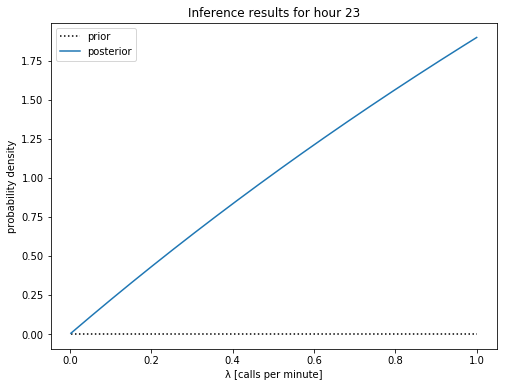

In [78]:
# YOU NEED TO PLOT THE PRIOR AND POSTERIOR ON THE SAME AXES.
plt.figure(figsize=(8, 6))
plt.plot(lambdas, prior(lambdas), color='black', linestyle=':', label='prior')
plt.plot(lambdas, posterior, label='posterior')
plt.xlabel('λ [calls per minute]')
plt.ylabel('probability density')
plt.title(f'Inference results for hour {hour_index}')
plt.legend()
plt.show()